In [1]:
import importlib
import u_net_clean
from u_net_clean import UNet,get_images_masks,get_data,train_network
importlib.reload(u_net_clean)
import torch
import os
import numpy as np
import matplotlib.pyplot as plt
from cellpose import models, core

/opt/anaconda3/envs/unetenv/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
model = UNet()
model.load_state_dict(torch.load('/Users/rehanzuberi/Documents/Development/u_net_exploration/saved_model/modelone30epochs',map_location=torch.device('cpu')))
model.eval()

UNet(
  (encoder): Encoder(
    (encBlocks): ModuleList(
      (0): Block(
        (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (relu): ReLU()
        (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
      (1): Block(
        (conv1): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (relu): ReLU()
        (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
      (2): Block(
        (conv1): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (relu): ReLU()
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
    )
    (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (decoder): Decoder(
    (upconvs): ModuleList(
      (0): ConvTranspose2d(64, 32, kernel_size=(2, 2), stride=(2, 2))
      (1): ConvTranspose2d(32, 16, kernel_size=(2, 2), stride=(2, 2))
    )
    (de

In [5]:
images_path = os.getcwd() + '/812_plate/'
masks_path = os.getcwd() + '/812_plate_masks/'
images, masks = get_images_masks(images_path, masks_path,num_imgs=1)

X_train, X_test, y_train, y_test = get_data(images,masks,flows=True)

mks 1: [0.         0.02058922 0.03495283 ... 0.97308654 0.9879761  1.        ]
(1, 1080, 1080)
Printing shapes
torch.Size([10, 1, 256, 256])
torch.Size([10, 1, 256, 256])


In [6]:
new_X = []
for i in range(len(X_train)):
    image = X_train[i]
    image_tosave = np.copy(image)
    image_input = image.detach().cpu().numpy()
    image_input = np.expand_dims(image_input,-1)
    image_input = np.moveaxis(image_input,-1,0)
    image_input = torch.from_numpy(image_input)
    image_input = image_input.type(torch.float32)
    result = model(image_input)
    result = np.squeeze(result)
    result = result.detach().cpu().numpy()
    new_X.append(result)
new_X = np.array(new_X)

In [7]:
print(type(new_X[1]))

<class 'numpy.ndarray'>


In [9]:
def reg_data(imgs, cellpose_model):
    #get the cellprobs as those will be the Xs
    #get the cellpose masks as those will be the Ys

    binary_masks = []
    for i in range(len(imgs)):
        masks, flows, styles = cellpose_model.eval(imgs[i],channels=[[0,0]],cellprob_threshold=0.0)

        #print('len masks',len(masks))
        masks = np.array(masks)
        print(masks.shape)
        binary_masks.append(np.where(masks>0,1,0))



    #cellprobs = []
    #for i in range(len(flows)):
    #    cellprobs.append(flows[i])

    #binary_masks = []
    #for i in range(len(masks)):
    #    binary_masks.append(np.where(masks[i]>0,1,0))

    #plt.subplot(2,2,1)
    #plt.imshow(cellprobs[0])

    #plt.subplot(2,2,2)
    #plt.imshow(binary_masks[0])

    #plt.subplot(2,2,3)
    #plt.imshow(cellprobs[1])

    #plt.subplot(2,2,4)
    #plt.imshow(binary_masks[1])

    #plt.show()


    return binary_masks

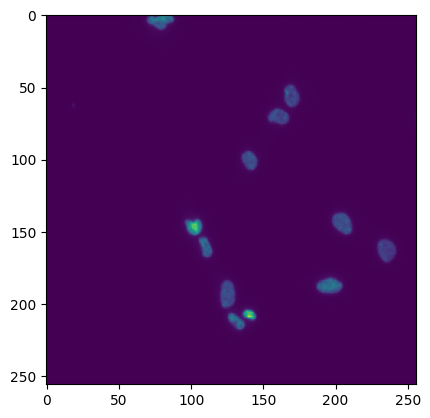

In [10]:
plt.imshow(X_train[0][0])

In [12]:
new_Y = []
cellpose_model = models.CellposeModel(model_type='nuclei',gpu=core.use_gpu())
binary_masks =  reg_data(np.squeeze(X_train.detach().cpu().numpy()),cellpose_model)
print(np.squeeze(X_train.detach().cpu().numpy()).shape)

(256, 256)
(256, 256)
(256, 256)
(256, 256)


KeyboardInterrupt: 

NameError: name 'binary_masks' is not defined

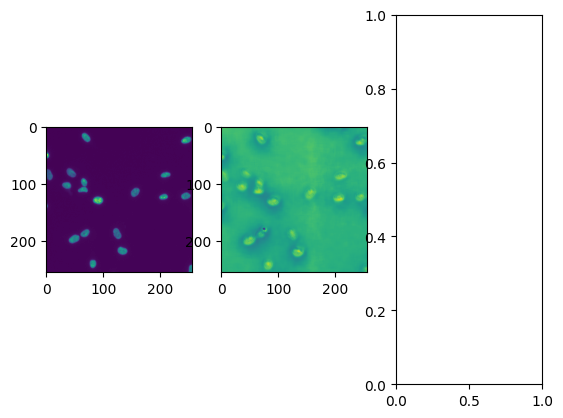

In [13]:
img_id = 2
plt.subplot(1,3,1)
plt.imshow(np.squeeze(X_train[img_id]))
plt.subplot(1,3,2)
plt.imshow(np.squeeze(new_X[img_id]))
plt.subplot(1,3,3)
plt.imshow(np.squeeze(binary_masks[img_id]))

In [10]:
print(new_X.shape)

binary_masks = np.array(binary_masks)
print(binary_masks.shape)

(670, 256, 256)
(670, 256, 256)


In [11]:
new_X = np.squeeze(new_X)
new_X = np.expand_dims(new_X,-1)
new_X = np.moveaxis(new_X,-1,1)

print(';xxx',new_X.shape)


;xxx (670, 1, 256, 256)


In [12]:
binary_masks = np.squeeze(binary_masks)
binary_masks = np.expand_dims(binary_masks,-1)
binary_masks = np.moveaxis(binary_masks,-1,1)
binary_masks = binary_masks.astype('float32')

print(';xxx',binary_masks.shape)

;xxx (670, 1, 256, 256)


In [13]:
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
print(torch.cuda.is_available())
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)


#images_path = os.getcwd() + '/812_plate/'
#masks_path = os.getcwd() + '/812_plate_masks/'
#images, masks = get_images_masks(images_path, masks_path,num_imgs=1)

X_train, X_test, y_train, y_test = train_test_split(new_X,binary_masks)

print(X_train.shape)

DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
PIN_MEMORY = True

trainDS = [(X_train[i],y_train[i]) for i in range(len(X_train))]
testDS = [(X_test[i],y_test[i]) for i in range(len(X_test))]

trainLoader = DataLoader(trainDS, shuffle=True,
                    batch_size=5, pin_memory=PIN_MEMORY,
                    num_workers=2)

testLoader = DataLoader(testDS, shuffle=True,
                        batch_size=5, pin_memory=PIN_MEMORY,
                        num_workers=2)

#print(X_train[0].shape)

#unet = UNet().to(DEVICE)
#unet.eval()

unet = train_network(trainLoader, testLoader, NUM_EPOCHS=5)

True
cuda:0
(502, 1, 256, 256)
[INFO] training the network...
[INFO] EPOCH: 1/5
       Train loss: 0.130725, Test loss: 0.037318
[INFO] EPOCH: 2/5
       Train loss: 0.027396, Test loss: 0.023371
[INFO] EPOCH: 3/5
       Train loss: 0.020564, Test loss: 0.019397
[INFO] EPOCH: 4/5
       Train loss: 0.017634, Test loss: 0.017257
[INFO] EPOCH: 5/5
       Train loss: 0.018829, Test loss: 0.017343
[INFO] total time taken to train the model: 30.57s


In [29]:
torch.save(unet, os.getcwd() +'/saved_model/secondunet')

In [14]:
print(np.array(binary_masks).shape)

(670, 1, 256, 256)


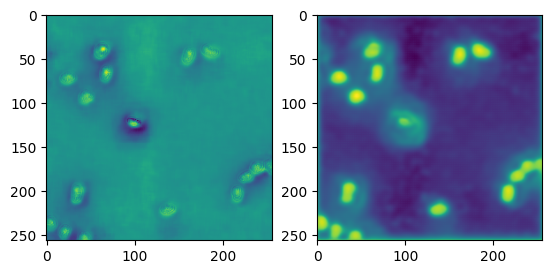

In [15]:
unet.eval()

image = X_test[0]
image_tosave = np.copy(image)
#image_input = image.detach().cpu().numpy()
image_input = np.expand_dims(image,-1)
image_input = np.moveaxis(image_input,-1,0)
image_input = torch.from_numpy(image_input)
image_input = image_input.type(torch.float32)
#image_input = image_input.to('mps')
image_input = image_input.to("cuda:0")
image_input = image_input.float()

pred = unet(image_input)

plt.subplot(1,2,1)
plt.imshow(np.squeeze(X_test[0]))
plt.subplot(1,2,2)
plt.imshow(np.squeeze(pred.detach().cpu().numpy()))
plt.show()

sigmoid: [1.0891737e-10 1.1688360e-10 1.2271395e-10 ... 9.9674040e-01 9.9680626e-01
 9.9683589e-01]


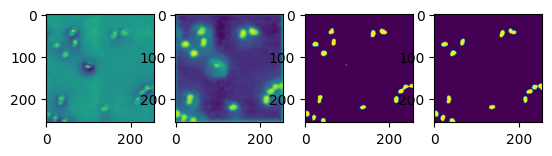

In [28]:
pred_d = pred.detach().cpu().numpy()
sigmoided = torch.sigmoid(torch.tensor(pred_d))
print('sigmoid:',np.unique(sigmoided))

tresh = np.where(sigmoided > 0.5,1,0)
plt.subplot(1,4,1)
plt.imshow(np.squeeze(X_test[0]))
plt.subplot(1,4,2)
plt.imshow(np.squeeze(pred.detach().cpu().numpy()))
plt.subplot(1,4,3)
plt.imshow(np.squeeze(tresh))
plt.subplot(1,4,4)
plt.imshow(np.squeeze(y_test[0]))

In [30]:
images_path = os.getcwd() + '/812_plate/'
masks_path = os.getcwd() + '/812_plate_masks/'
images, masks = get_images_masks(images_path, masks_path,num_imgs=1)

In [ ]:
from empatches import EMPatches



def pred_from_ori(img,model1,model2):
    emp = EMPatches()
    img_patches, indices = emp.extract_patches(images[0][:,:,0], patchsize=256, overlap=0.2)

images_path = os.getcwd() + '/812_plate/'
masks_path = os.getcwd() + '/812_plate_masks/'
images, masks = get_images_masks(images_path, masks_path,num_imgs=1)
model1 = model
model2 = unet
pred_from_ori(images[0][:,:,0],model1,model2)

In [44]:
def patchify(img, patch_shape):
    img = np.ascontiguousarray(img)  # won't make a copy if not needed
    X, Y = img.shape
    x, y = patch_shape
    shape = ((X-x+1), (Y-y+1), x, y) # number of patches, patch_shape
    # The right strides can be thought by:
    # 1) Thinking of `img` as a chunk of memory in C order
    # 2) Asking how many items through that chunk of memory are needed when indices
    #    i,j,k,l are incremented by one
    strides = img.itemsize*np.array([Y, 1, Y, 1])
    return np.lib.stride_tricks.as_strided(img, shape=shape, strides=strides)

In [48]:
print(images[0][:,:,0].shape)

(1080, 1080)


In [49]:
resu = patchify(images[0][:,:,0],(256,256))

In [51]:
print(resu.shape)

(825, 825, 256, 256)


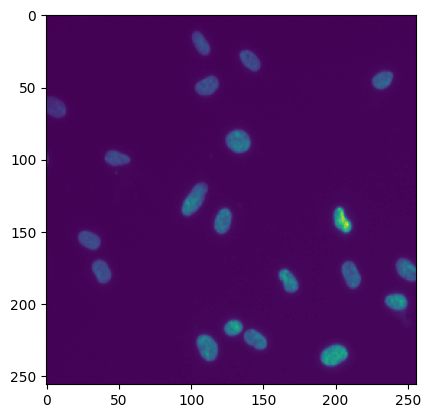

In [52]:
plt.imshow(resu[0][0])

In [60]:
from empatches import EMPatches

emp = EMPatches()
img_patches, indices = emp.extract_patches(images[0][:,:,0], patchsize=256, overlap=0.2)

In [68]:
print(len(img_patches))
print(img_patches[0].shape)

36
(256, 256)


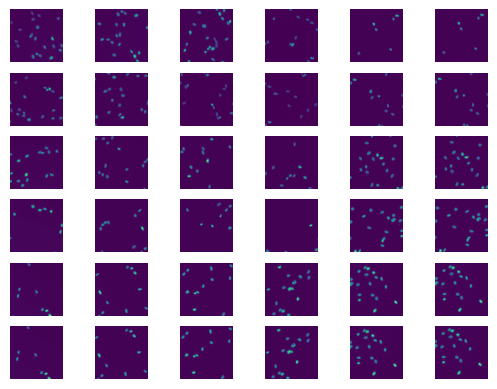

In [67]:
for i in range(36):
    plt.subplot(6,6,i+1)
    plt.imshow(img_patches[i])
    plt.axis('off')
plt.show()